# Analiza filmów na podstawie danych JSON

Notebook przedstawia analizę filmów na podstawie danych z pliku `movie_analysis_report.json` oraz na podstawie wykresów wygenerowanych przez skrypt `movie_processing/analyze_movies.py`. Znajdują się tutaj wykresy, statystyki oraz opisy przedstawiające różne aspekty danych filmowych, takie jak gatunki, oceny czy spójność ocen.

Wyniki przedstawiono w formie wykresów (załączonych w osobnych plikach `.png`) wraz z opisami metodologii oraz wnioskami.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image, display
import json

plt.style.use('bmh')

In [2]:
with open('results/movie_analysis_report.json', 'r') as file:
    data = json.load(file)

## 📊  Podstawowe statystyki
Te dane pokazują ogólne tendencje w analizowanej bazie filmów.

In [3]:
basic_stats = pd.DataFrame({
    'Value': {
        'Liczba filmów': data['basic_stats']['total_movies'],
        'Średnia ocena': f"{data['basic_stats']['avg_rating']:.2f}",
        'Średnia spójność ocen': f"{data['basic_stats']['avg_consistency']:.2f}", 
        'Średnie zaangażowanie widzów': f"{data['basic_stats']['avg_engagement']:.2f}"
    }
})

basic_stats

,Value
Liczba filmów,12000
Średnia ocena,6.68
Średnia spójność ocen,1.87
Średnie zaangażowanie widzów,0.39


Metryka średniego zaangażowania widzów została obliczona jako ważona suma różnych metryk znormalizowana do zakresu 0-1:

```python
engagement_score = (
    stats['watchers'] * 0.3 +
    stats['plays'] * 0.2 +
    stats['collectors'] * 0.15 +
    stats['comments'] * 0.15 +
    stats['lists'] * 0.1 +
    stats['votes'] * 0.1
) / max_stats
```

W podobny sposób obliczono wskaźnik sukcesu filmów:

```python
success_index = (
    stats['rating'] * 0.4 +
    stats['votes'] * 0.2 +
    stats['engagement_score'] * 0.2 +
    stats['translation_count'] * 0.2
) / max_stats
```

## 📊 Średnia ocena filmów w różnych gatunkach
Poniższy wykres przedstawia średnią ocenę filmów w różnych gatunkach. Gatunki takie jak **dokumentalne** oraz **anime** wyróżniają się najwyższymi ocenami, podczas gdy **horrory** wypadają najsłabiej.

Wykres zapisano w pliku `avg_rating_by_genre.png`.


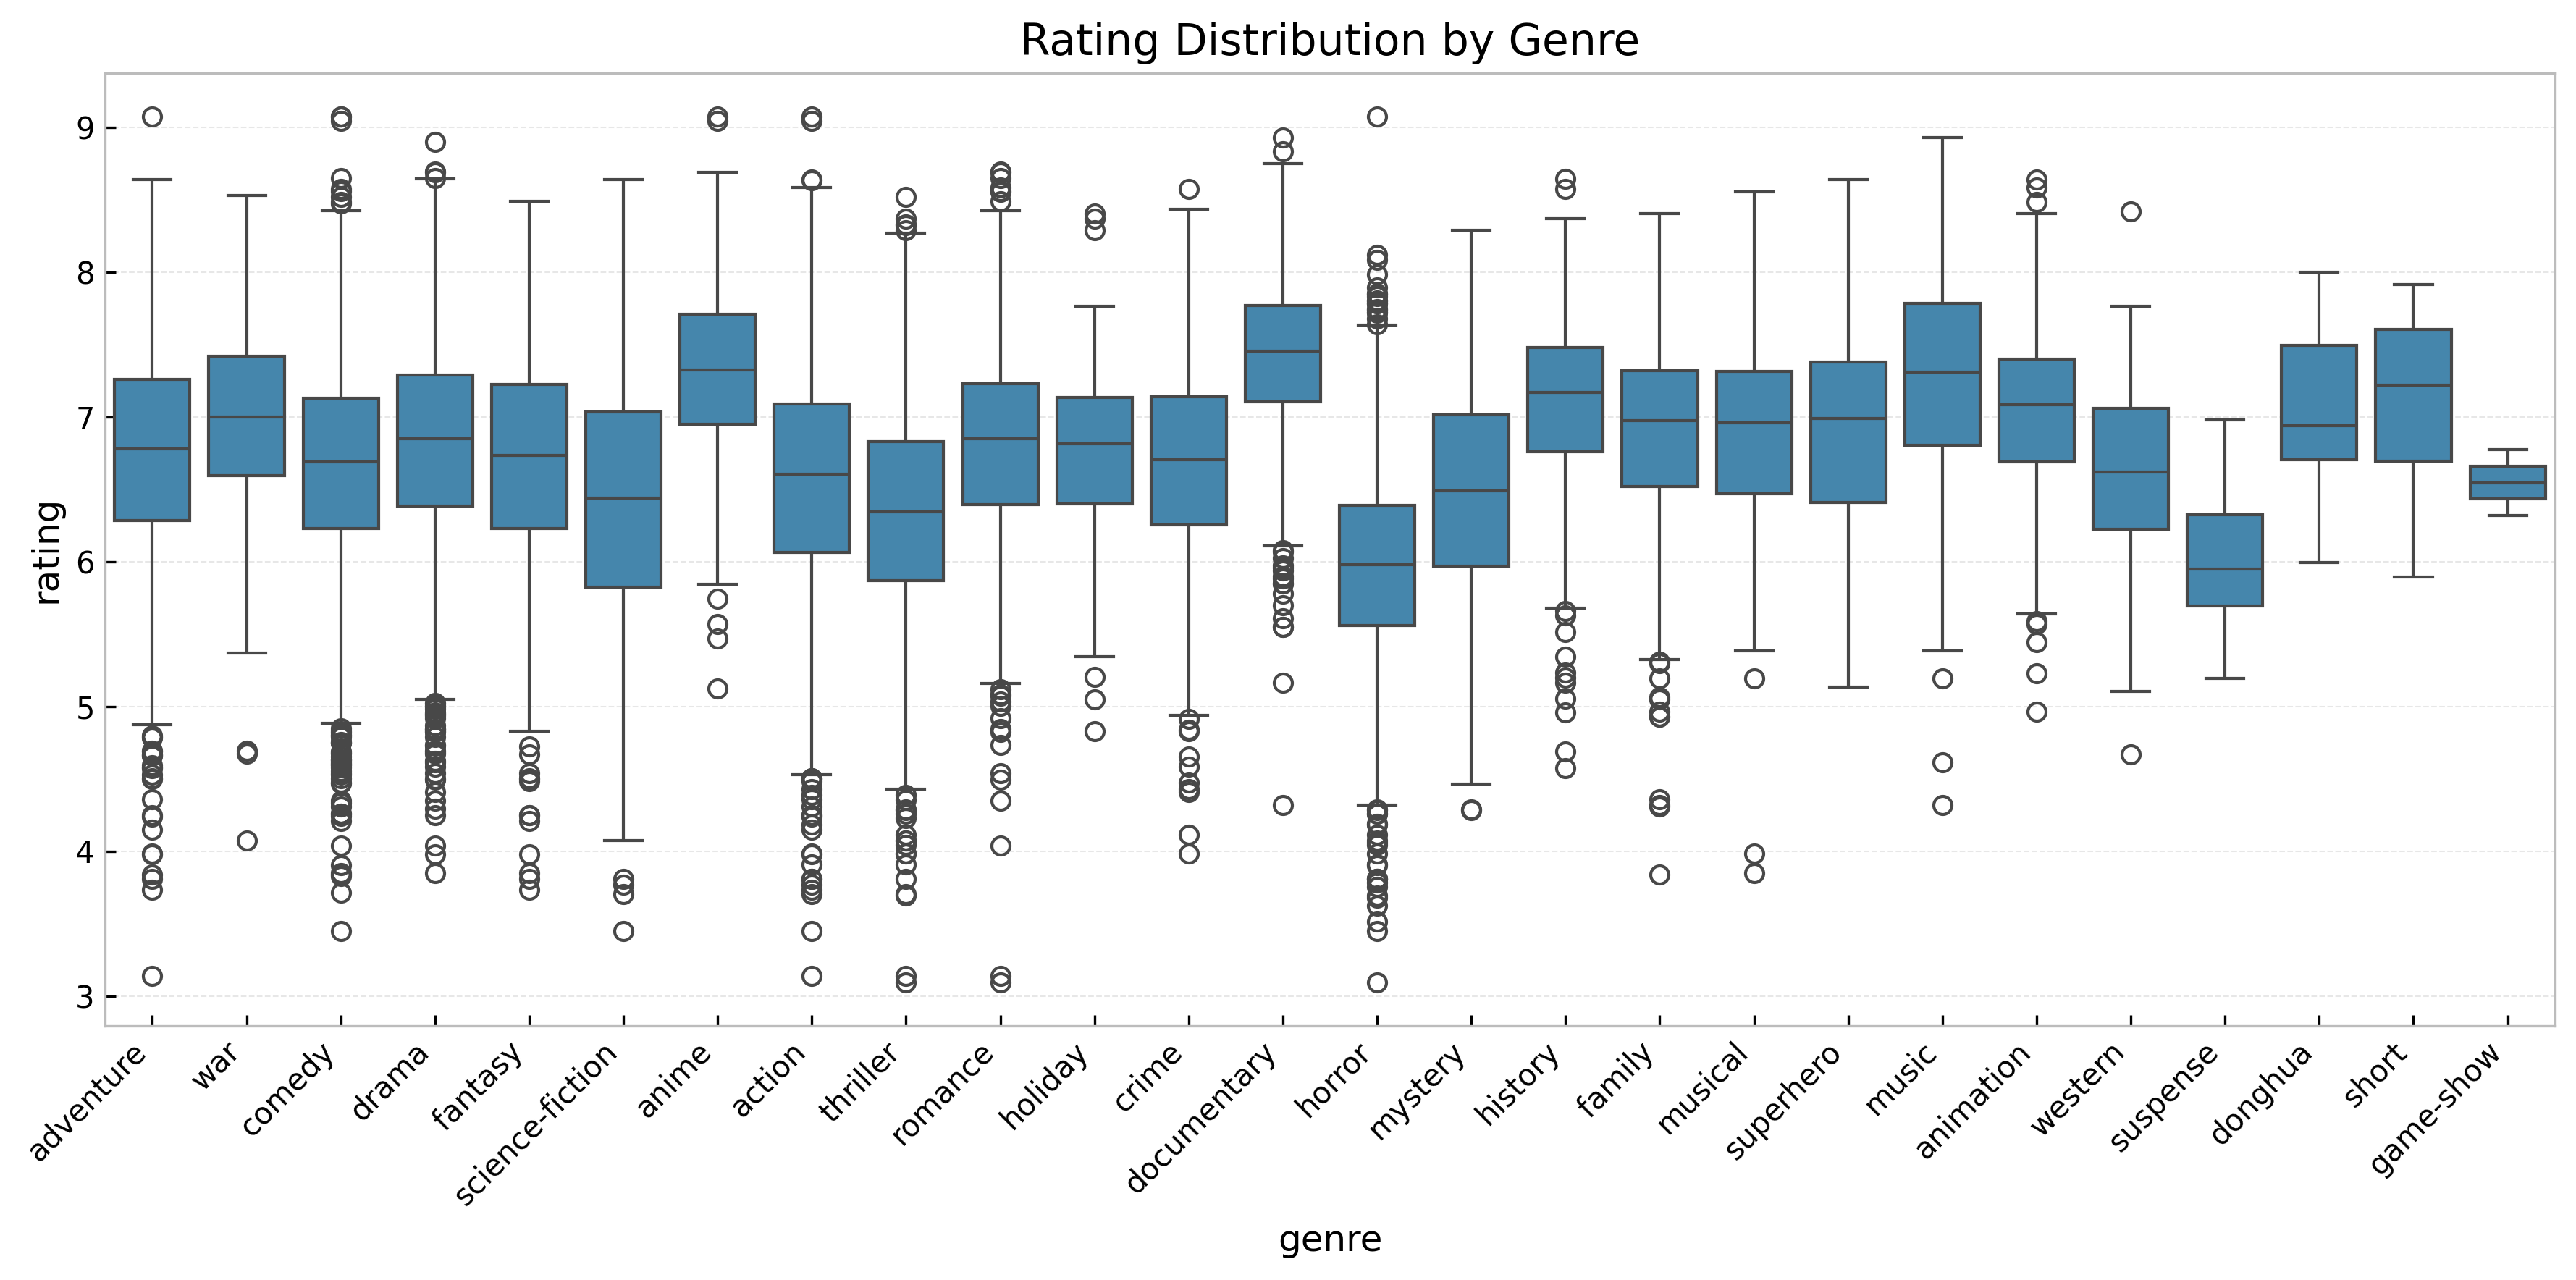

In [4]:
display(Image(filename='results/plots/genre_ratings.png'))

Część gatunków jest mało reprezentowana w tym datasecie, z czego mogą wynikać niewielkie zakresy ocen niektórych z gatunków.

Poniższa tabela pokazuje średnie oceny, spójność oraz liczbę filmów w poszczególnych gatunkach. Bierze pod uwagę tylko gatunki, które mają co najmniej 500 filmów.

In [5]:
genres_df = pd.DataFrame.from_dict(data['genre_impact'], orient='index')
genres_df = genres_df.round(2)
genres_df.columns = ['Average Rating', 'Average Consistency', 'Movie Count']

# Filtrowanie gatunków z co najmniej 500 filmami
major_genres = genres_df[genres_df['Movie Count'] >= 500].sort_values('Average Rating', ascending=False)

major_genres.style.background_gradient(cmap='viridis', subset=['Average Rating'])\
    .background_gradient(cmap='coolwarm_r', subset=['Average Consistency'])\
    .background_gradient(cmap='YlOrRd', subset=['Movie Count'])

,Average Rating,Average Consistency,Movie Count
documentary,7.410000,1.700000,948
history,7.110000,1.710000,563
animation,7.040000,1.890000,776
family,6.900000,1.940000,1064
drama,6.820000,1.830000,4957
romance,6.810000,1.870000,1753
adventure,6.730000,1.890000,1293
fantasy,6.700000,1.910000,1020
crime,6.680000,1.810000,1450
comedy,6.660000,1.870000,3842


## 🧾 Korelacje spójności ocen z innymi zmiennymi
Analiza korelacji ujawnia:
- **Korelacja spójności z liczbą głosów:** -0.153
- **Korelacja spójności z oceną:** -0.558

Negatywna korelacja oznacza, że wyższa spójność ocen wiąże się z mniejszą liczbą głosów oraz niższymi ocenami.


In [6]:
corr_votes = data['rating_consistency']['correlation_with_votes']
corr_rating = data['rating_consistency']['correlation_with_rating']

print(f"Korelacja spójności z liczbą głosów: {corr_votes}")
print(f"Korelacja spójności z oceną: {corr_rating}")

Korelacja spójności z liczbą głosów: -0.15262401200560252
Korelacja spójności z oceną: -0.5578872360502795


## 🗂️ Najbardziej spójne i niespójne filmy, top filmy
Poniższy wykres przedstawiaja ocenę vs spójność ocen filmów. Zaznaczono filmy o najwyższej i najniższej spójności ocen oraz rop 5 filmów z największym wskaźnikiem sukcesu.

- Filmy o wysokiej spójności mają małe odchylenie standardowe ocen.
- Filmy o niskiej spójności (np. **"Justin Bieber's Believe"**) cechują się dużymi różnicami opinii widzów.

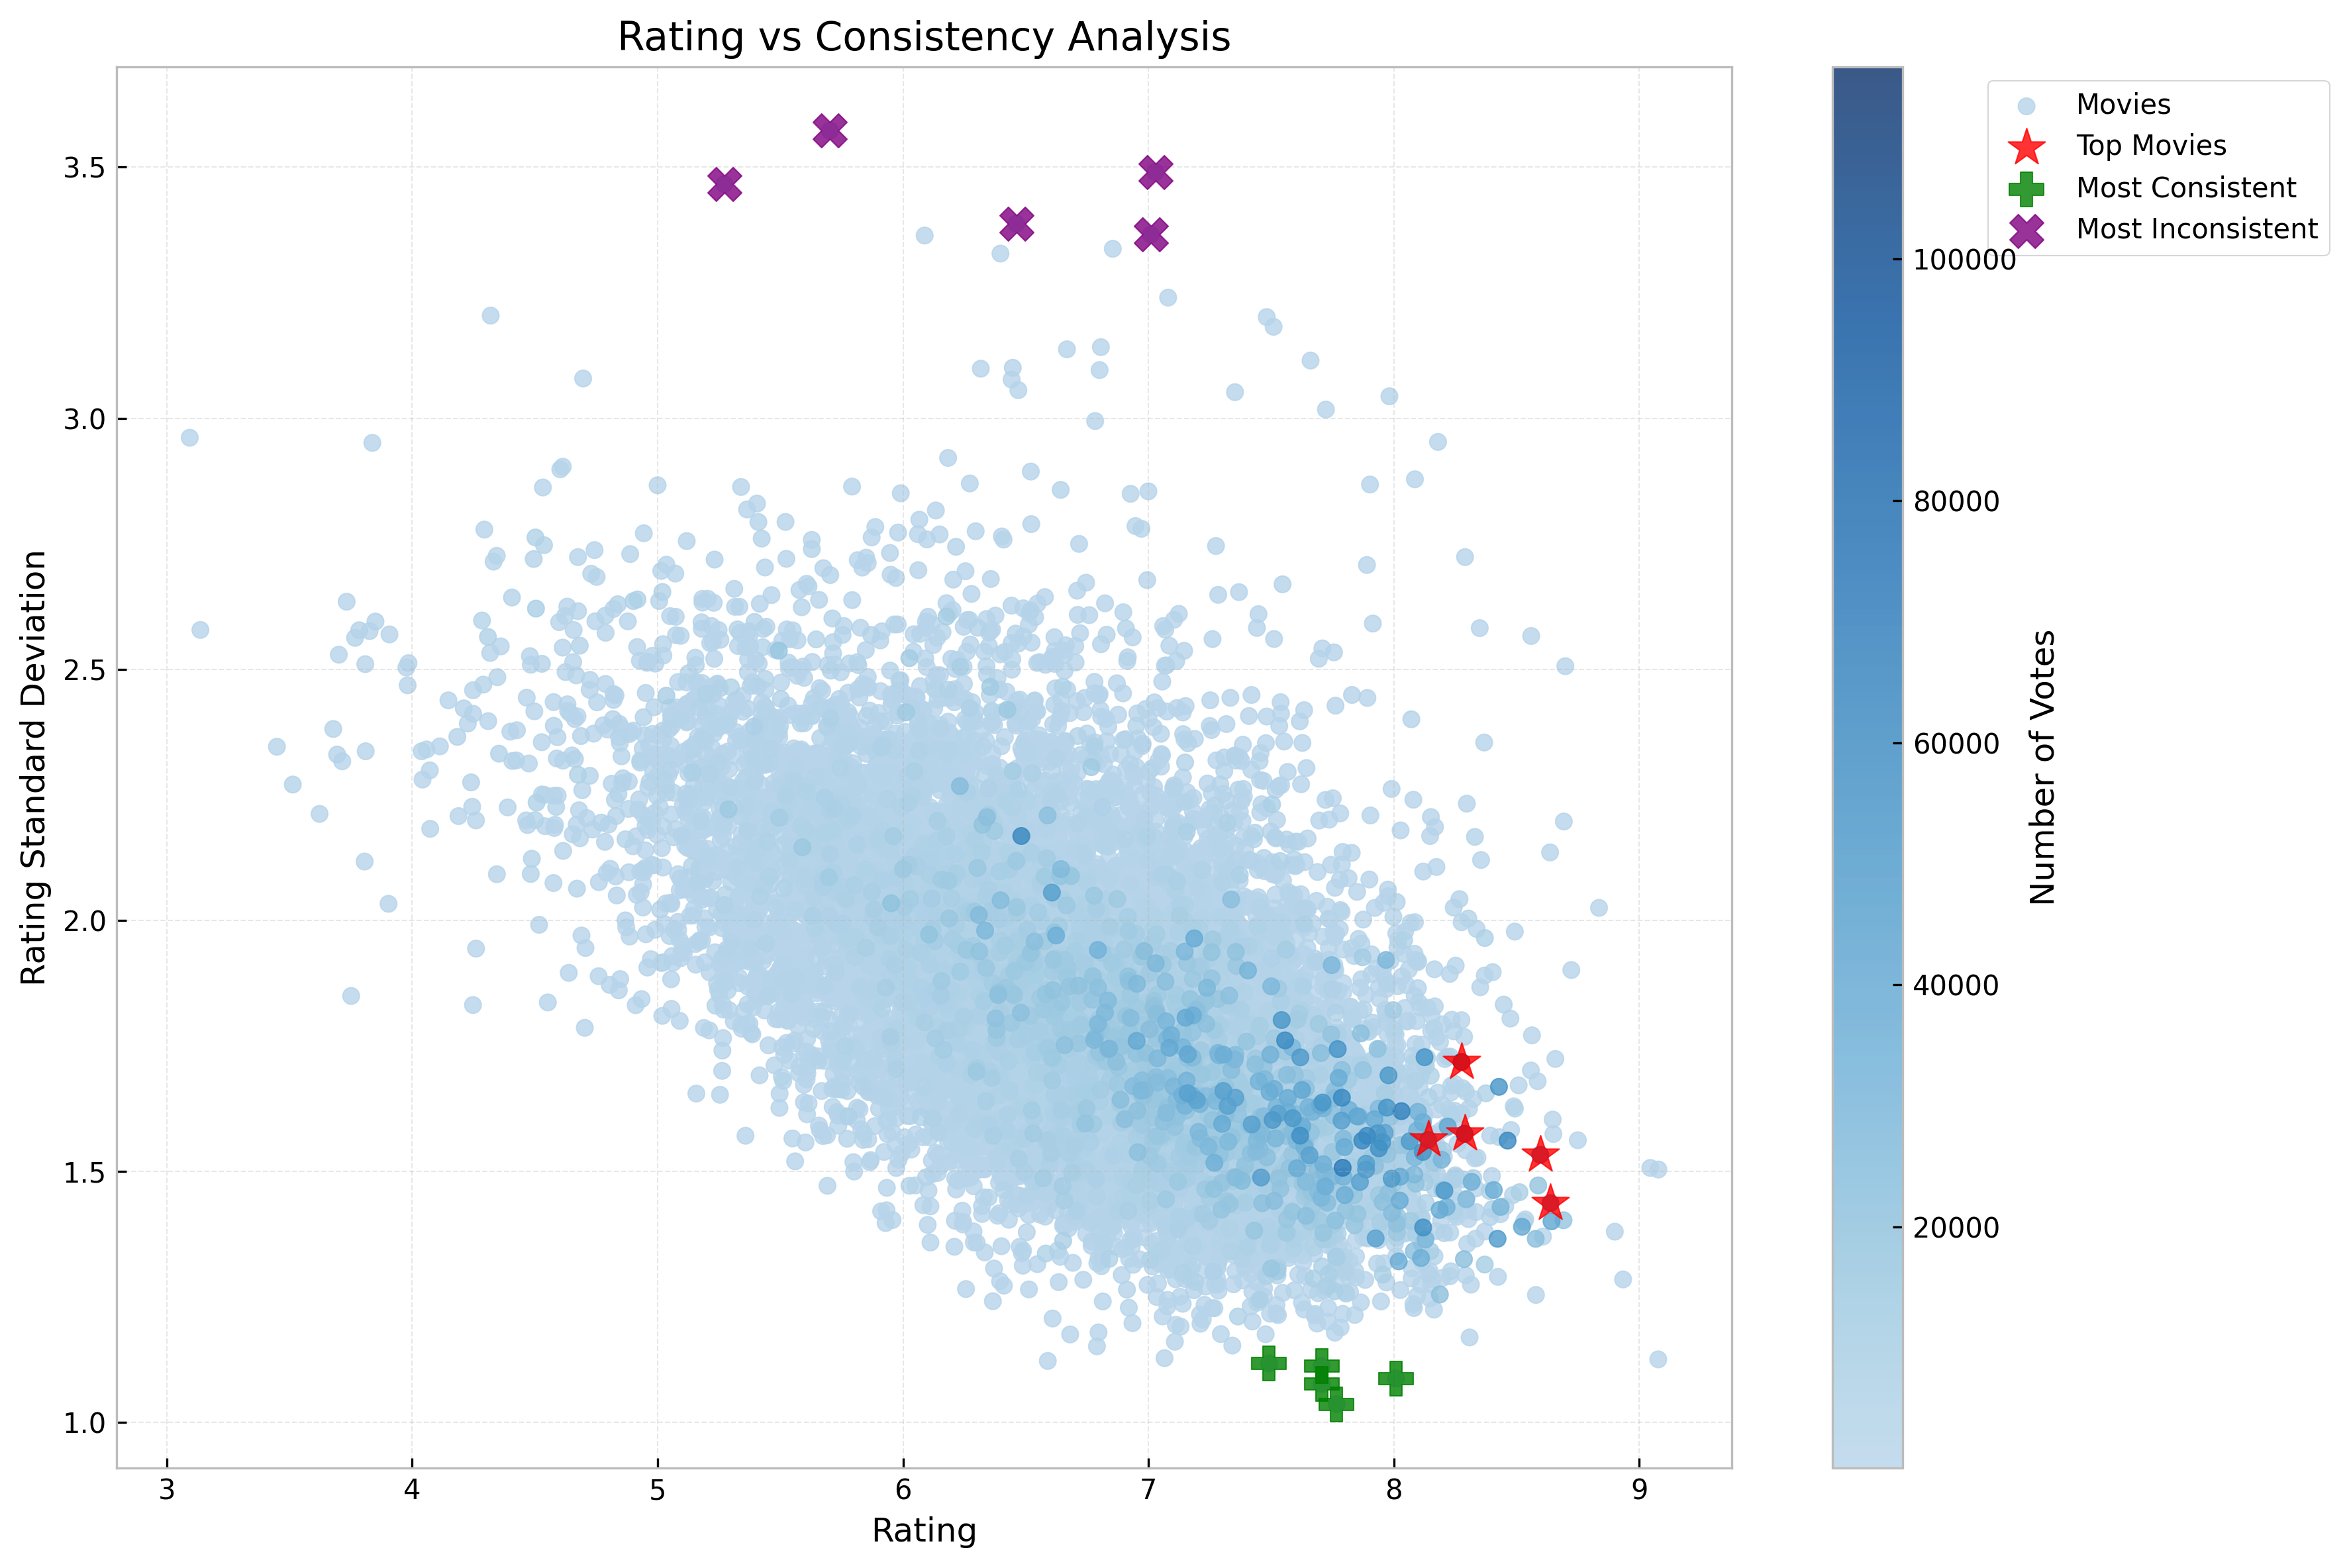

In [7]:
# Wyświetlenie wykresów spójności
display(Image(filename='results/plots/rating_consistency.png'))

### Najbardziej spójne i niespójne filmy - ich dokładne oceny i odchylenie standardowe

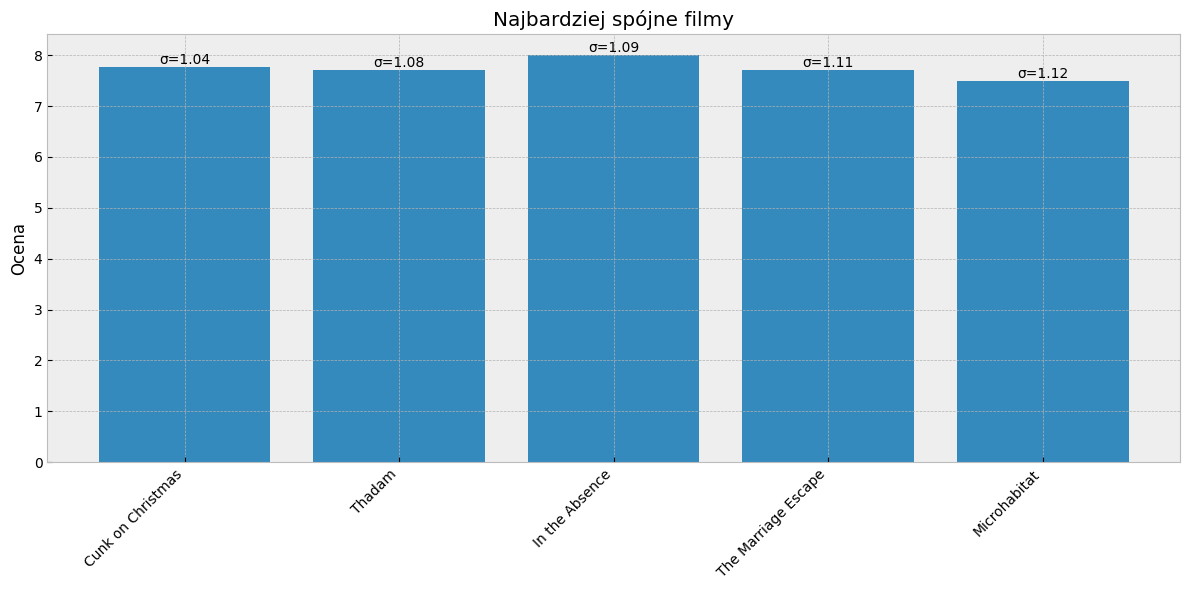

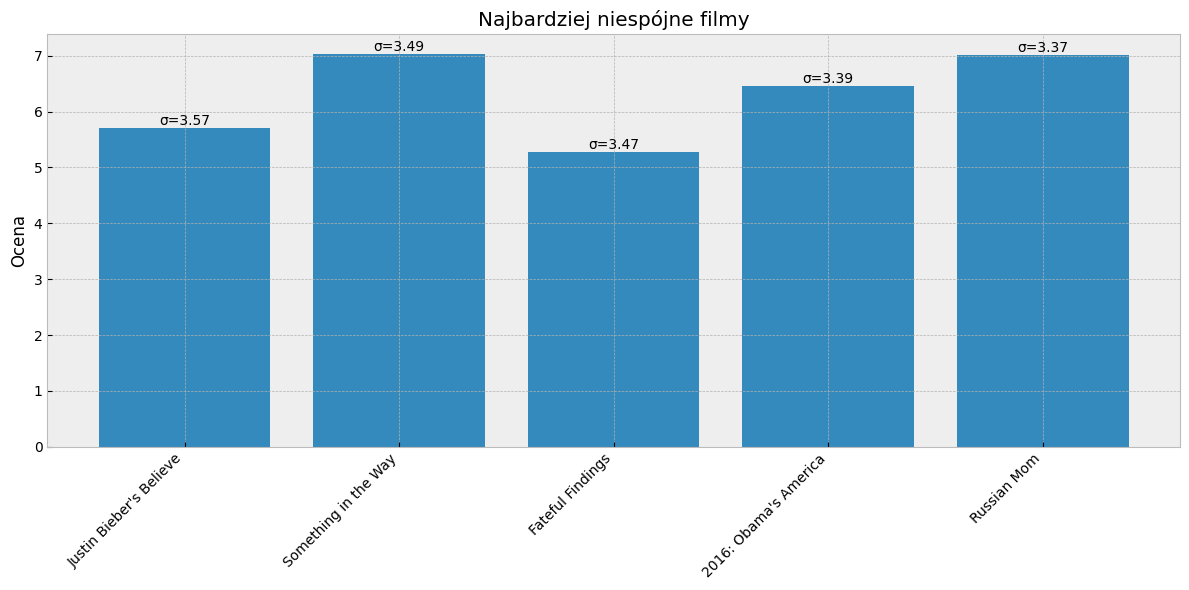

In [8]:
def plot_movie_ratings(movies_data: dict, title: str) -> None:
    df = pd.DataFrame(movies_data)
    df = df.round(2)
    df.columns = ['Title', 'Rating', 'Consistency (std)']

    plt.figure(figsize=(12, 6))
    bars = plt.bar(df['Title'], df['Rating'])
    plt.xticks(rotation=45, ha='right')
    plt.title(title)
    plt.ylabel('Ocena')

    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'σ={df["Consistency (std)"].iloc[i]}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_movie_ratings(data['rating_consistency']['most_consistent'], 
                  'Najbardziej spójne filmy')
plot_movie_ratings(data['rating_consistency']['most_inconsistent'],
                  'Najbardziej niespójne filmy')

Symbol σ na wykresach jest odchyleniem standardowym ocen. Top 5 najbardziej spójnych filmów ma bardzo podobne średnie oceny. Z niespójnymi jest różnie, ale posiadają one oceny bliskie oceny średniej czyli 5/10.

## ✅ Sukcesy filmów
Poniższy wykres przedstawia 10 filmów o najwyższym wskaźniku sukcesu. Wśród najlepszych znajdują się takie filmy jak **"Deadpool"**, **"Guardians of the Galaxy"** czy **"Interstellar"**.

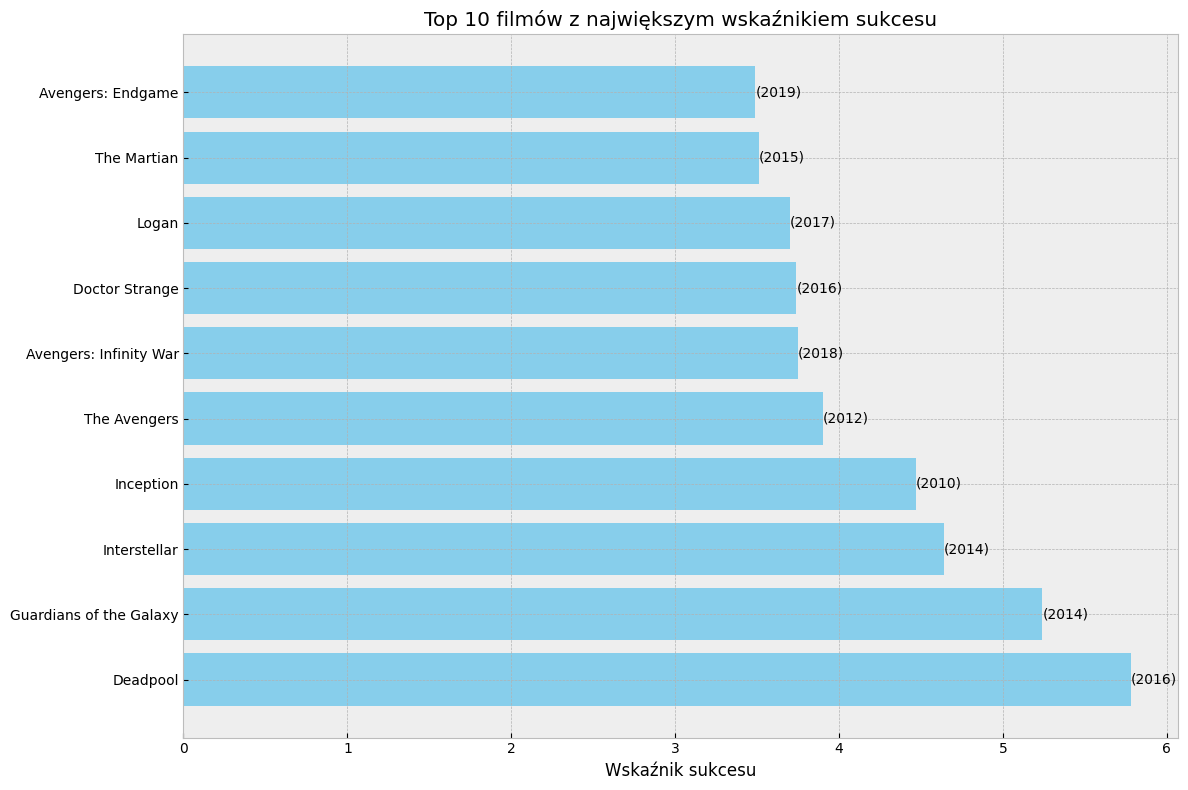

In [9]:
top_movies_df: pd.DataFrame = pd.DataFrame(data['top_movies'])
top_movies_df['success_index'] = top_movies_df['success_index'].round(2)

plt.figure(figsize=(12, 8))
bars = plt.barh(top_movies_df['title'], top_movies_df['success_index'], color='skyblue')
plt.xlabel('Wskaźnik sukcesu')
plt.title('Top 10 filmów z największym wskaźnikiem sukcesu')

for bar, year in zip(bars, top_movies_df['year']):
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"({year})",
        va='center',
        ha='left'
    )

plt.tight_layout()
plt.show()

## 🕐 Analiza czasowa cech

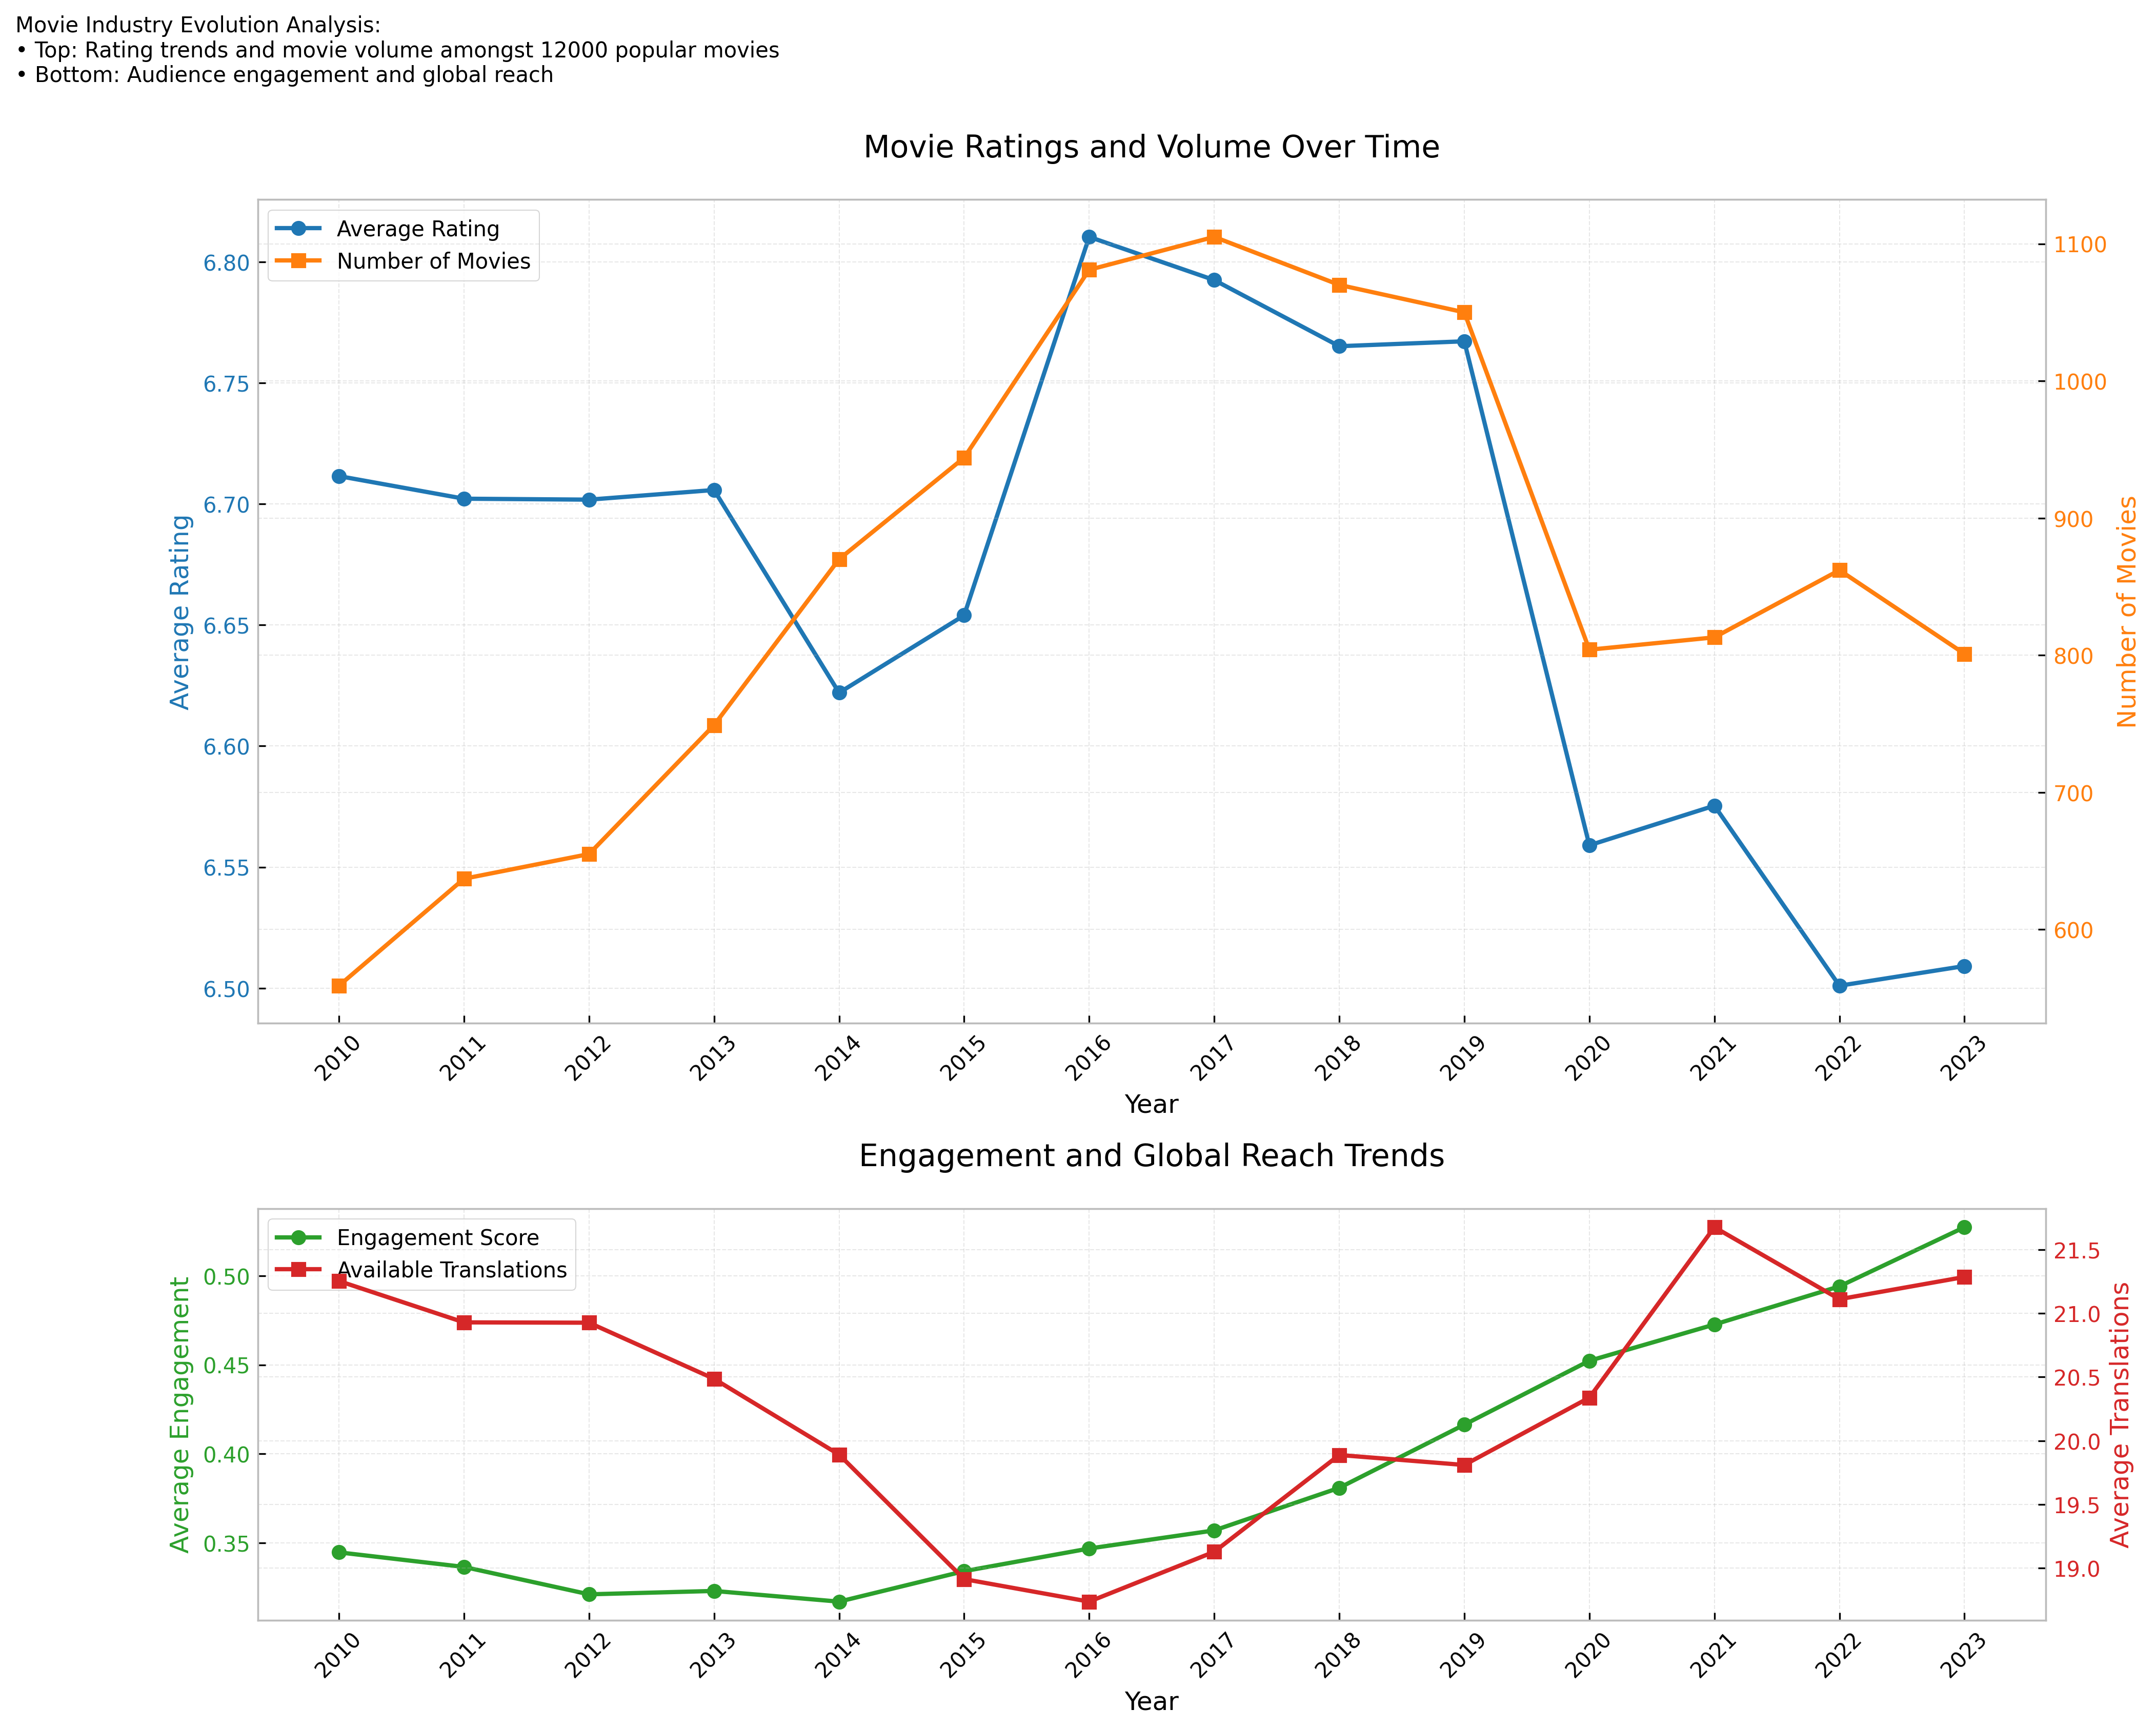

In [10]:
# Wyświetlenie wykresów analizy czasowej
display(Image(filename='results/plots/timeline_analysis.png'))

Możemy zauważyć, że filmy po roku 2020 zrobiły się średnio gorsze. W latach 2014 - 2019 powstawało więcej topowych filmów niż obecnie.

Zwiększona produkcja filmów była związana ze zmniejszeniem dostępnej liczby tłumaczeń.
Wynik średniego zaangażowania widzów był najniższy w latach 2015 - 2017. Obecnie jest całkiem wysoki, podobny do lat 2010 - 2012.

## Podsumowanie
Analiza filmów ujawnia następujące wnioski:
1. Dokumentalne i anime osiągają najwyższe oceny, podczas gdy horrory są oceniane najsłabiej.
2. Spójność ocen jest odwrotnie skorelowana z liczbą głosów oraz średnią oceną.
3. Filmy z wysokim wskaźnikiem sukcesu to głównie produkcje z dużym budżetem i popularne wśród widzów.

Dalsze analizy mogłyby uwzględnić np. wpływ reżyserów, budżetu czy specyfikę danych lat na oceny filmów.